# Setup

In [154]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import sys

# Load data

In [155]:
comparison_folder = os.path.join(os.getcwd(),'data', 'BF_approximation_comparison')
bridge_file = '2021_06_29___15_12_BF_approx_comp'
NN_fixed_file = '2021_07_13___17_52_BF_NN_comp'
NN_variable_file = '2021_07_01___15_24_BF_NN_variable_comp'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))

In [156]:
bridge.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,m0_bridge_error,m1_bridge_error,compile_time,stan_time,bridge_time
0,1,0,8.388963e-01,0.161104,0,1.920424e-01,0%,0%,39.907145,52.258780,35.962266
1,2,1,2.226466e-27,1.000000,1,4.491424e+26,0%,0%,39.907145,48.838711,35.385838
2,3,1,5.490843e-01,0.450916,0,8.212140e-01,1%,1%,39.907145,125.710194,37.204897
3,4,0,7.737407e-01,0.226259,0,2.924226e-01,0%,0%,39.907145,48.535535,35.359315
4,5,0,5.384046e-01,0.461595,0,8.573394e-01,0%,0%,39.907145,49.718692,35.450406


In [5]:
NN_fixed.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.830657,0.169343,0,0.203867,160.790968,0.055943,0.474433
1,2,1,0.000056,0.999944,1,17961.758030,160.790968,0.055943,0.474433
2,3,1,0.550600,0.449400,0,0.816201,160.790968,0.055943,0.474433
3,4,0,0.856114,0.143886,0,0.168069,160.790968,0.055943,0.474433
4,5,0,0.552386,0.447614,0,0.810329,160.790968,0.055943,0.474433


In [6]:
NN_variable.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time
0,1,0,0.824269,0.175731,0,0.213197,238.349188,0.014821
1,2,1,0.001745,0.998255,1,572.129368,238.349188,0.014821
2,3,1,0.353277,0.646723,1,1.830639,238.349188,0.014821
3,4,0,0.630828,0.369172,0,0.585218,238.349188,0.014821
4,5,0,0.556635,0.443365,0,0.796510,238.349188,0.014821


# Calculate performance metrics

In [86]:
def performance_metrics(bridge_sampling_results, NN_fixed_results, NN_variable_results, names):
    
    mae = []
    rmse = []
    roc_auc = [] 
    accuracy = []
    
    for d in (bridge_sampling_results, NN_fixed_results, NN_variable_results):
        mae_temp = np.mean(abs(d['true_model']-d['m1_prob']))
        mae.append(mae_temp)
        rmse_temp = np.sqrt(((d['true_model']-d['m1_prob'])**2).mean())
        rmse.append(rmse_temp)
        roc_auc_temp = roc_auc_score(d['true_model'], d['m1_prob'])
        roc_auc.append(roc_auc_temp)
        accuracy_temp = (d['true_model'] == d['selected_model']).mean()
        accuracy.append(accuracy_temp)

    
    df = pd.DataFrame([mae, rmse, roc_auc, accuracy], index = ['MAE', 'RMSE', 'ROC AUC', 'Accuracy'], 
                      columns = names).transpose()
    
    return df

In [87]:
perf_metrics = performance_metrics(bridge, NN_fixed, NN_variable, 
                                   names = ['Bridge Sampling', 'Hierarchical Network fixed', 
                                            'Hierarchical Network variable'])
perf_metrics

,MAE,RMSE,ROC AUC,Accuracy
Bridge Sampling,0.228593,0.322116,0.941176,0.86
Hierarchical Network fixed,0.255016,0.349507,0.907163,0.82
Hierarchical Network variable,0.255145,0.333028,0.922769,0.83


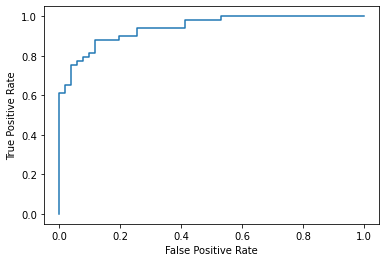

In [85]:
fpr, tpr, thesholds = roc_curve(bridge['true_model'], bridge['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

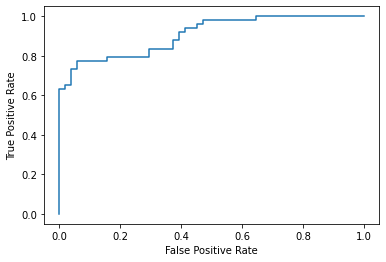

In [81]:
fpr, tpr, thesholds = roc_curve(NN_fixed['true_model'], NN_fixed['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

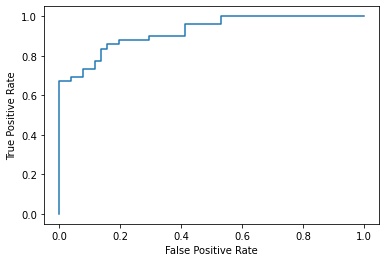

In [82]:
fpr, tpr, thesholds = roc_curve(NN_variable['true_model'], NN_variable['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

In [46]:
# Inspired by simulation-based calibration: 
# Do the average posterior probabilities match the 50/50 prior 
# / the 49/51 proportion in the simulated datasets?

print('True prior probability for m1 = {}'.format(0.5))
print('True proportion in simulated datasets = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling average m1 probability = {}'.format(bridge['m1_prob'].mean()))
print('NN fixed average m1 probability = {}'.format(NN_fixed['m1_prob'].mean()))
print('NN variable average m1 probability = {}'.format(NN_variable['m1_prob'].mean()))

True prior probability for m1 = 0.5
True proportion in simulated datasets = 0.49
Bridge Sampling average m1 probability = 0.4974335423669033
NN fixed average m1 probability = 0.4510535007715225
NN variable average m1 probability = 0.5137272714078427


In [11]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))
print('NN variable proportion = {}'.format(NN_variable['selected_model'].mean()))

True proportion = 0.49
Bridge Sampling proportion = 0.39
NN fixed proportion = 0.33
NN variable proportion = 0.46


# Plot log BF approximation

In [12]:
### Variant 1: Replace infinite BFs by highest number possible

def log_with_inf_replacement(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    if all(np.isfinite(x)) == False:
        x_copy[np.isfinite(x) == False] = sys.maxsize
    x_copy = np.log(x_copy)
    return x_copy

In [32]:
### Variant 2: Add noise to model probs in case of infinite BFs and recompute BFs

def log_with_inf_noise_addition(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    for i in range(x.shape[0]):
        if x.loc[i,'m0_prob'] == 0:
            x_copy.loc[i,'m0_prob'] = x_copy.loc[i,'m0_prob'] + 0.000000001
            x_copy.loc[i,'m1_prob'] = x_copy.loc[i,'m1_prob'] - 0.000000001
            x_copy.loc[i,'bayes_factor'] = x_copy.loc[i,'m1_prob'] / x_copy.loc[i,'m0_prob']
    x_copy = np.log(x_copy['bayes_factor'])
    return x_copy

In [160]:
np.exp(10)

22026.465794806718

In [27]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)
log_NN_variable_bfs = log_with_inf_noise_addition(NN_variable)

In [165]:
np.sort(bridge['bayes_factor'].loc[bridge['bayes_factor'] < 50])

array([ 0.08976884,  0.10249567,  0.10340879,  0.11279363,  0.11655228,
        0.12507037,  0.12866583,  0.12998589,  0.13637609,  0.14099811,
        0.14238797,  0.14402889,  0.14536824,  0.14855502,  0.14909988,
        0.1539192 ,  0.15816054,  0.16257114,  0.17579001,  0.1810069 ,
        0.18103744,  0.18288746,  0.18927806,  0.19204243,  0.19508471,
        0.19748363,  0.2071235 ,  0.23590953,  0.23716463,  0.24239773,
        0.24890857,  0.27037473,  0.28814861,  0.29242265,  0.30044889,
        0.30115403,  0.3016934 ,  0.30403035,  0.33064646,  0.34172327,
        0.38301918,  0.3966449 ,  0.43967894,  0.4410801 ,  0.44645651,
        0.45325386,  0.50028493,  0.53555951,  0.54822107,  0.56028597,
        0.61063063,  0.64712925,  0.69179539,  0.72765541,  0.75566254,
        0.82121396,  0.85733935,  0.85925063,  0.90040455,  0.94491869,
        0.99638602,  1.06234148,  1.11735588,  1.19155001,  1.26478246,
        1.29098694,  1.74674693,  2.21875415,  3.60067273,  5.65

In [153]:
np.sort(log_NN_fixed_bfs)

array([-2.74314832, -2.53192959, -2.52527042, -2.48463708, -2.46906376,
       -2.44615344, -2.43138707, -2.40361641, -2.39902503, -2.39360874,
       -2.36014938, -2.34561758, -2.25358673, -2.17310179, -2.16871886,
       -2.09889674, -2.06950382, -1.97629362, -1.92520663, -1.92390712,
       -1.88929541, -1.78337823, -1.76818457, -1.67472821, -1.62342865,
       -1.59028778, -1.56039822, -1.47751186, -1.43012695, -1.42551868,
       -1.38156444, -1.3111948 , -1.25953616, -1.23300926, -1.1844259 ,
       -1.17310065, -1.13835242, -1.10854789, -1.09311444, -1.04038768,
       -1.02288413, -0.99681427, -0.97711973, -0.97366402, -0.93080648,
       -0.88350244, -0.86992945, -0.86501201, -0.84961992, -0.83028217,
       -0.79317831, -0.72574113, -0.67118694, -0.62999576, -0.60382491,
       -0.5572531 , -0.43185949, -0.41485847, -0.32348576, -0.28578658,
       -0.21874572, -0.21031553, -0.20309448, -0.13770999, -0.12299427,
       -0.07824978, -0.0345082 ,  0.00841766,  0.33976356,  0.40

In [58]:
bridge[['bayes_factor','true_model']]

,bayes_factor,true_model
0,1.920424e-01,0
1,4.491424e+26,1
2,8.212140e-01,1
3,2.924226e-01,0
4,8.573394e-01,0
...,...,...
95,9.449187e-01,1
96,1.453682e-01,0
97,1.024957e-01,0
98,1.539192e-01,0


In [174]:
# Compute BFs up to 100 (based on Bridge Sampling BFs)

bridge_bfs_till_100 = bridge[['bayes_factor','true_model']].loc[bridge['bayes_factor'] <= 100]
NN_fixed_bfs_till_100 = NN_fixed['bayes_factor'].loc[bridge['bayes_factor'] <= 100]
NN_variable_bfs_till_100 = NN_variable['bayes_factor'].loc[bridge['bayes_factor'] <= 100]

In [47]:
# Plotting settings

colors = {0:'darkgrey', 1:'black'}

Text(0.5, 1.0, 'Posterior probability approximation: Hierarchical Network trained with fixed dataset sizes')

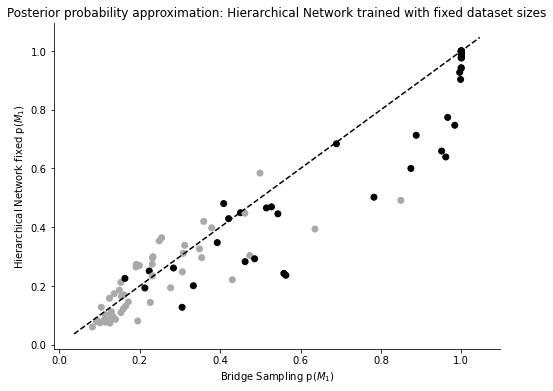

In [134]:
# Posterior probabilities for model 1
# Bridge Sampling vs fixed NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bridge['m1_prob'], NN_fixed['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling p($M_{1}$)')
ax.set_ylabel('Hierarchical Network fixed p($M_{1}$)')
ax.set_title('Posterior probability approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Log Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')

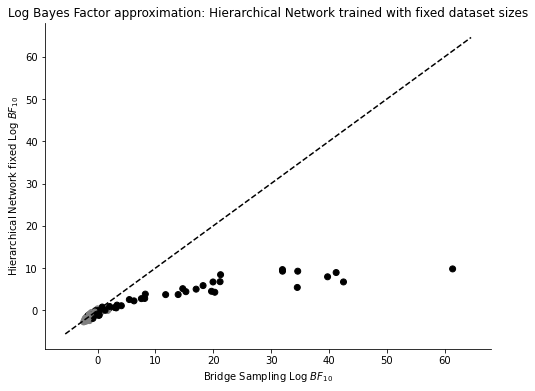

In [30]:
# BFs vs fixed NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(log_bridge_bfs, log_NN_fixed_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling Log $BF_{10}$')
ax.set_ylabel('Hierarchical Network fixed Log $BF_{10}$')
ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Bayes Factor approximation for BF <= 100: Hierarchical Network trained with fixed dataset sizes')

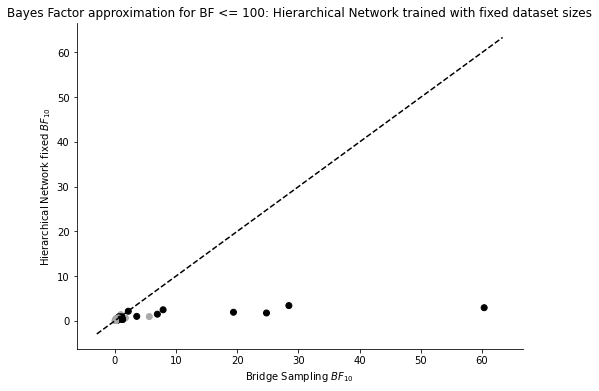

In [175]:
# Plot BFs up to 100 (based on Bridge Sampling BFs)

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bridge_bfs_till_100['bayes_factor'], NN_fixed_bfs_till_100, c=bridge_bfs_till_100['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling $BF_{10}$')
ax.set_ylabel('Hierarchical Network fixed $BF_{10}$')
ax.set_title('Bayes Factor approximation for BF <= 100: Hierarchical Network trained with fixed dataset sizes')

In [35]:
# Show only BFs that lead to different decisions (Modellselektion ungleich)
df = pd.DataFrame([bridge['bayes_factor'].loc[bridge['selected_model'] != NN_fixed['selected_model']],
                   NN_fixed['bayes_factor'].loc[bridge['selected_model'] != NN_fixed['selected_model']],
                   bridge['true_model'].loc[bridge['selected_model'] != NN_fixed['selected_model']]]).T
df.columns = ['Bridge Sampling', 'NN_fixed', 'True model']
df['True model'] = df['True model'].astype(int)
df

,Bridge Sampling,NN_fixed,True model
5,1.746747,0.649301,0
19,5.652058,0.966080,0
27,0.996386,1.404615,0
29,1.062341,0.871351,1
40,1.290987,0.309406,1
47,1.191550,0.803526,1
77,1.117356,0.884269,1
99,1.264782,0.320346,1


Text(0.5, 1.0, 'Posterior probability approximation: Hierarchical Network trained with variable dataset sizes')

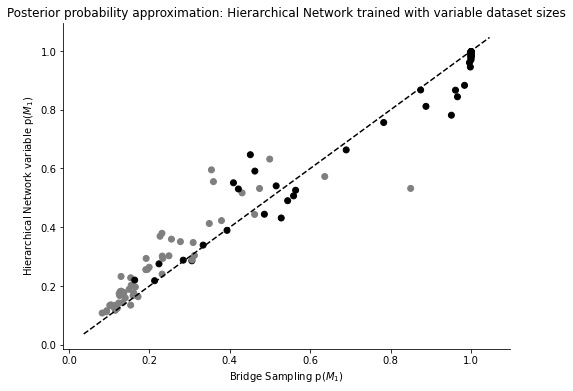

In [38]:
# Posterior probabilities for model 1
# Bridge Sampling vs variable NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bridge['m1_prob'], NN_variable['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling p($M_{1}$)')
ax.set_ylabel('Hierarchical Network variable p($M_{1}$)')
ax.set_title('Posterior probability approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Log Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')

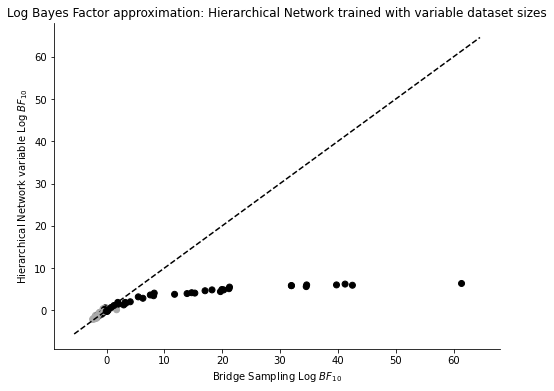

In [170]:
# vs variable NN

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(log_bridge_bfs, log_NN_variable_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling Log $BF_{10}$')
ax.set_ylabel('Hierarchical Network variable Log $BF_{10}$')
ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Bayes Factor approximation for BF <= 100: Hierarchical Network trained with variable dataset sizes')

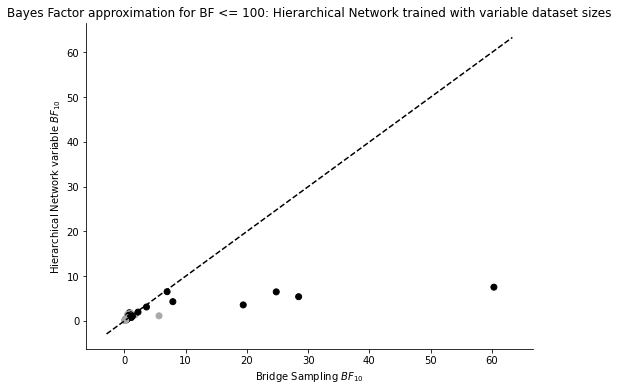

In [171]:
# Plot BFs up to 100 (based on Bridge Sampling BFs)

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(bridge_bfs_till_100['bayes_factor'], NN_variable_bfs_till_100, c=bridge_bfs_till_100['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Bridge Sampling $BF_{10}$')
ax.set_ylabel('Hierarchical Network variable $BF_{10}$')
ax.set_title('Bayes Factor approximation for BF <= 100: Hierarchical Network trained with variable dataset sizes')

In [41]:
# Show only BFs that lead to different decisions (Modellselektion ungleich)
df = pd.DataFrame([bridge['bayes_factor'].loc[bridge['selected_model'] != NN_variable['selected_model']],
                   NN_variable['bayes_factor'].loc[bridge['selected_model'] != NN_variable['selected_model']],
                   bridge['true_model'].loc[bridge['selected_model'] != NN_variable['selected_model']]]).T
df.columns = ['Bridge Sampling', 'NN_variable', 'True model']
df['True model'] = df['True model'].astype(int)
df

,Bridge Sampling,NN_variable,True model
2,0.821214,1.830639,1
16,0.560286,1.247811,0
27,0.996386,1.716274,0
28,0.859251,1.445082,1
35,0.548221,1.470246,0
37,0.755663,1.069422,0
47,1.191550,0.961479,1
66,0.900405,1.135542,0
75,0.727655,1.128338,1
77,1.117356,0.758457,1


# Plot Computation time as function of datasets

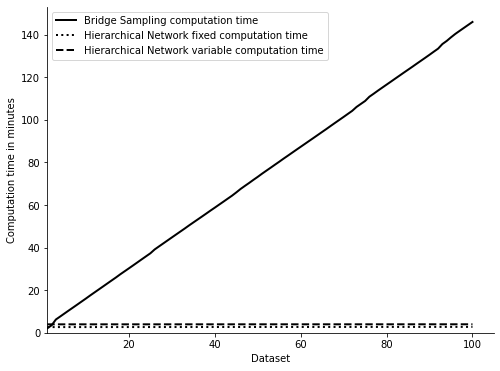

In [113]:
# Plot for all datasets

# Calculate computation times
bridge_time_min = (bridge['compile_time'] + (bridge['stan_time'] + bridge['bridge_time']).cumsum())/60
NN_fixed_time_min = (NN_fixed['training_time'] + NN_fixed['inference_time'].cumsum())/60
NN_variable_time_min = (NN_variable['training_time'] + NN_variable['inference_time'].cumsum())/60

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, color='black')
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', color='black')
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset')
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.legend(loc='upper left')
f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')

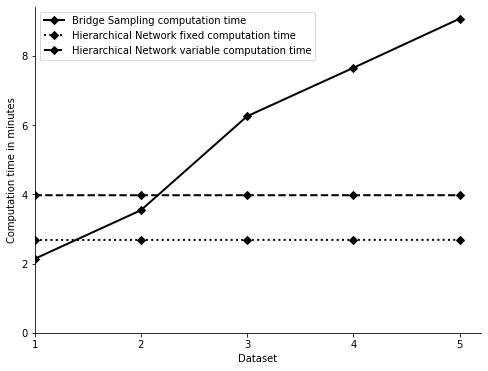

In [114]:
# Plot time for subset of 1-5 datasets

bridge_short = bridge.iloc[:5,:]
NN_fixed_short = NN_fixed.iloc[:5,:]
NN_variable_short = NN_variable.iloc[:5,:]

# Calculate computation times
bridge_time_min = ((bridge_short['compile_time'] + (bridge_short['stan_time'] + bridge_short['bridge_time']).cumsum())/60)
NN_fixed_time_min = ((NN_fixed_short['training_time'] + NN_fixed_short['inference_time'].cumsum())/60)
NN_variable_time_min = ((NN_variable_short['training_time'] + NN_variable_short['inference_time'].cumsum())/60)

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, marker='D', color='black')
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', marker='D', color='black')
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', marker='D', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Dataset')
ax.set_ylabel('Computation time in minutes')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.set_xticks(bridge_time_min.index) # only display ticks for each dataset
ax.legend(loc='upper left')
f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')